# Caso de negocio para Rappi. Detección de Fraudes. 

Autor: Benjamín Tello. Fecha: 09/10/2022

Esta notebook se divide en tres partes. En la parte (1) hacemos un análisis exploratorio de los datos. En la parte (2) clasificamos a los clientes de acuerdo a un score que definimos como la razón entre el total de sus gastos al mes y su limite de crédito, y discutimos las implicaciones para el negocio de lo encontrado. En la parte (3) desarrollamosun modelo Random Forest para la detección de fraude, y discutimos los hallazgos. 

In [6]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Poner aqui la ruta derl archivo "ds_challenge_data_2022.csv"
csv_path = "C:/Users/tello/Desktop/Rappi/ds_challenge_data_2022.csv"

# Leer el CSV en un Pandas DataFrame
rappi_df = pd.read_csv(csv_path)

#Ponemos el no. de transacción como indice del data frame
rappi_df=rappi_df.set_index("transaction_id")

#Tiramos las observaciones en las que monto==1, ya que no son transacciones relevantes sino solo de comprobación.
rappi_df=rappi_df[rappi_df["monto"]>1]

# 1. Exploración y análisis de los datos

In [8]:
#Obtenemos summary statistics de las variables numércias
print(rappi_df[[ "monto","cashback", "linea_tc", "interes_tc","dcto",]].describe())

              monto      cashback      linea_tc    interes_tc          dcto
count  25719.000000  25719.000000  25719.000000  25719.000000  25719.000000
mean     538.839130     17.749426  62485.166608     48.242389      5.631154
std      273.763036     10.481262  21887.326521      9.588657     12.561238
min        1.050000      0.030000  25000.000000     32.000000      0.000000
25%      332.965000     10.500000  44000.000000     40.000000      0.000000
50%      524.170000     16.500000  63000.000000     49.000000      0.000000
75%      727.140000     23.240000  82000.000000     57.000000      0.000000
max     1712.700000    109.730000  99000.000000     64.000000     85.640000


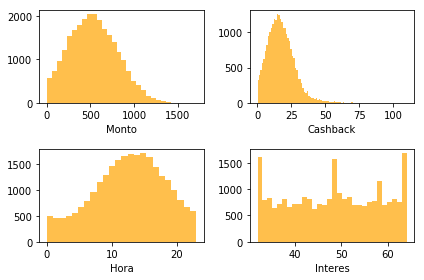

In [4]:
#Histogramas
fig, ax = plt.subplots(2,2)

ax[0,0].hist(rappi_df["monto"], bins=30, color="orange", alpha=0.7)
ax[0,0].set(xlabel='Monto')
ax[0,1].hist(rappi_df["cashback"], bins=100,color="orange", alpha=0.7)
ax[0,1].set(xlabel="Cashback")
ax[1,0].hist(rappi_df["hora"], bins=24, color="orange", alpha=0.7)
ax[1,0].set(xlabel="Hora")
ax[1,1].hist(rappi_df["interes_tc"], bins=30, color="orange", alpha=0.7)
ax[1,1].set(xlabel="Interes")

#fig.suptitle('Transacciones')
fig.tight_layout()
plt.show()

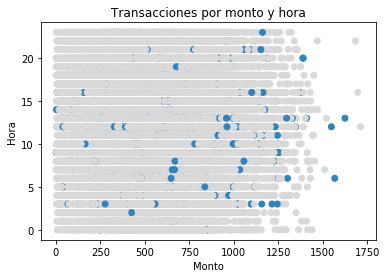

In [5]:
# Este gráfico nos permite identificar en que horas y montos se cometen los fraudes

fig, ax = plt.subplots()

ax.scatter(x = rappi_df["monto"], y = rappi_df["hora"], c = rappi_df["fraude"], cmap="tab20c_r")

# Previous customizations
#plt.xscale('log') 
plt.xlabel('Monto')
plt.ylabel('Hora')
plt.title('Transacciones por monto y hora')


# Show the plot
plt.show()

In [6]:
#Creamos un data frame donde tiramos las observaciones en los que "establecimientos" tiene NA
rappi_df_est=rappi_df.dropna(subset=["establecimiento"])

#creamos series con los maximos y minimos por establecimiento

monto_max=rappi_df_est.groupby("establecimiento")["monto"].max()
monto_min=rappi_df_est.groupby("establecimiento")["monto"].min()
monto_mean=rappi_df_est.groupby("establecimiento")["monto"].mean()
monto_median=rappi_df_est.groupby("establecimiento")["monto"].median()


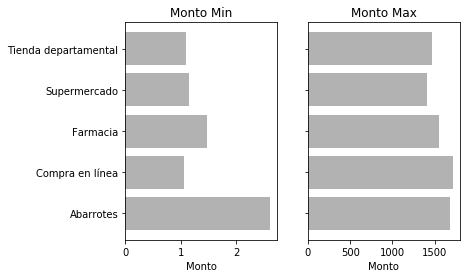

In [7]:
#Barplots de los montos max y min por establecimiento
fig, axs = plt.subplots(1,2)


axs[0].barh(monto_min.index,monto_min.values, color="gray", alpha=0.6)
axs[0].set_title("Monto Min")
axs[1].barh(monto_max.index,monto_max.values, color="gray", alpha=0.6)
axs[1].set_title("Monto Max")

for ax in axs.flat:
    ax.set(xlabel="Monto")

for ax in axs.flat:
    ax.label_outer()


plt.show()

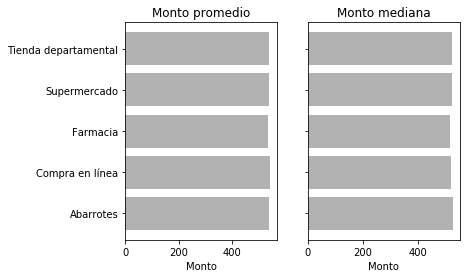

In [8]:
#Barplots de los montos promedio y mediano por establecimiento
fig, axs = plt.subplots(1,2)


axs[0].barh(monto_mean.index,monto_mean.values, color="gray", alpha=0.6)
axs[0].set_title("Monto promedio")
axs[1].barh(monto_median.index,monto_median.values, color="gray", alpha=0.6)
axs[1].set_title("Monto mediana")

for ax in axs.flat:
    ax.set(xlabel="Monto")

for ax in axs.flat:
    ax.label_outer()


plt.show()

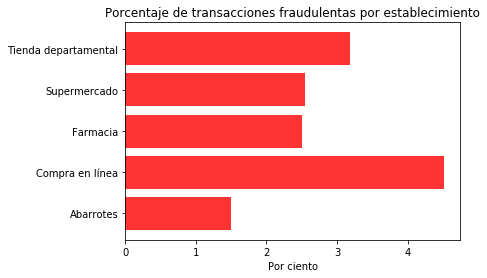

In [9]:
#Creamos Barplot de fraude por establecimiento 

fraude_est=rappi_df_est.groupby("establecimiento")["fraude"].mean()

#Barplots de los montos promedio y mediano por establecimiento
fig, ax = plt.subplots()
ax.set_title("Porcentaje de transacciones fraudulentas por establecimiento")

ax.barh(fraude_est.index, fraude_est.values*100, color="red", alpha=0.8)
ax.set(xlabel="Por ciento")
plt.show()


# 2. Categorización de los clientes en el dataset 

Generamos un score para cada cliente (score_cliente) como la razón del total de sus transacciones en el mes a su línea de crédito.

Este score nos indica lo siguiente:

-Los que tienen un score_cliente bajo son clientes que estan gastando poco con su tarjeta en relación a su linea de crédito. Quiza se deba incentivarlos a usar más su tarjeta.

-Para los clientes con un score_cliente elevado se debe vigilar su capacidad de pago o quizá ofrecerles una linea de crédito mayor.


In [10]:
#Con group by creamos 2 series. Una con la suma de las transacciones, otra con el limite de la linea de credito
# Generamos un score para cada cliente que es la razón del total de sus transacciones entre su linea de crédito.

compras=rappi_df.groupby("user_id")["monto"].sum()
limite=rappi_df.groupby("user_id")["linea_tc"].mean()
score_cliente=compras/limite


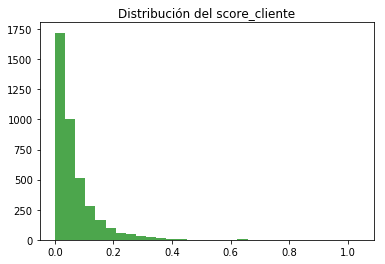

In [11]:
#Histogramas
fig, ax = plt.subplots()
ax.hist(score_cliente, bins=30, color="green", alpha=0.7)
ax.set_title("Distribución del score_cliente")

plt.show()

-Por lo que se aprecia en el histograma, se debe incentivar el uso de la TC en un amplio segmento de los clientes. Adicionalmente no parece haber riesgos grandes para el banco de que una masa crítica de clientes no pague.

# 3. Modelo para detectar transacciones fraudulentas

Vamos a entrenar un Random Forest para detectar defraudadores

Preparamos los datos para alimentar el RF a partir del data frame "rappi_df_est" iremos construyendo el df rappi_df que alimentará al RF.

In [12]:
#Nuevo data frame solo con varibales numericas

rappi_rf = rappi_df_est[["user_id","linea_tc", "interes_tc", "monto", "dcto", "cashback", "hora"]]

In [13]:
#Codificamos variables categóricas para incluirlas al data set rappi_df
#Codificamos la variable sexo

rappi_df_est=rappi_df_est[rappi_df_est["género"]!="N"]
sex = pd.get_dummies(rappi_df_est['género'])
sex=sex["F"]
rappi_rf = rappi_rf.merge(sex, on="transaction_id")

In [14]:
#Codificamos la variable establecimiento

est = pd.get_dummies(rappi_df_est['establecimiento'])
est=est.drop('Abarrotes', axis=1)
rappi_rf = rappi_rf.merge(est, on="transaction_id")

In [15]:
#Codificamos la variable ciudad

citi = pd.get_dummies(rappi_df_est['ciudad'])
citi=citi.drop('Cancún', axis=1)
rappi_rf = rappi_rf.merge(citi, on="transaction_id")


In [16]:
#Crear una variable que indique que dos transacciones se hicieron el mismo dia en distintas ciudades

#rappi_rf["sum_citis"]= rappi_rf["Cancún"]+ rappi_rf["Ciudad de México"]+ rappi_rf["Guadalajara"]+ rappi_rf["Monterrey"]+rappi_rf["Nezahualcóyotl"]+ rappi_rf["Tijuana"]+ rappi_rf["Toluca"]


In [17]:
#Codificamos la variable fraude

fraude = pd.get_dummies(rappi_df_est['fraude'])
fraude=fraude.drop(False, axis=1)
fraude=fraude.rename(columns={True:"fraude"})
rappi_rf = rappi_rf.merge(fraude, on="transaction_id")

In [18]:
#Codificamos la variable is_prime

prime = pd.get_dummies(rappi_df_est['is_prime'])
prime=prime.drop(False, axis=1)
prime=prime.rename(columns={True:"prime"})
rappi_rf = rappi_rf.merge(prime, on="transaction_id")
#rappi_rf.head()

# 3.1 Primero vamos a calcular la Accuracy natural. Es decir, la accuracy que tendriamos si predijeramos todas las transacciones como legitimas.


In [19]:
# Crear matrices para las características y la variable de respuesta
y = rappi_rf['fraude'].values
X = rappi_rf.drop(['fraude', "user_id"], axis=1).values

In [20]:
# Cuenta el número total de observaciones  de y
total_obs = len(y)

# Contar el número total de observaciones no fraudulentas 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

# Calcular el porcentaje de observaciones no fraudulentas en el conjunto de datos
percentage = (float(count_non_fraud)/float(total_obs)) * 100

# Imprime el porcentaje: esta es nuestra "precisión natural" al no hacer nada
print(percentage)

96.86401079050052


# 3.2 Random Forest Classifier 

In [21]:
# Importamos los modulos necesarios
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics 


In [22]:
# Partimos los datos en training y test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

# Define the model as the random forest
model = RandomForestClassifier(n_estimators = 30, random_state=5)

# Entrenamos el modelo con nuestros la muestra de entrenamiento
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

Cross validation

In [23]:
# hacemos 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(model, X, y, cv=5)

# Imprimimos los 5-fold cross-validation scores
print(cv_scores)

# Promedio de los 5-fold cross-validation score
print("Average 10-Fold CV Accuracy: {}".format(np.mean(cv_scores)*100))


[0.96845654 0.96844894 0.96868979 0.96868225 0.96892315]
Average 10-Fold CV Accuracy: 96.86401324113125


Nuestro RF no es mejor que clasificar a todas las transacciones como legales en terminos de "accuracy". Sin embargoen en este contexto, nos interesa atrapar el mayor número de casos de fraude posible, para eso debemos conseguir el mejor Recall.

A continuación vemos que el recall para la etiqueta de fraude es 0.01. Con este modelo solo fuimos capaces de identificar una transaccion frauduleta del total de 130 transacciones fraudulentas en nuestra muestra.

In [24]:
# Obtenemos predicciones con el test data
predicted = model.predict(X_test)

# imprimimos el classification report y la  confusion matrix
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4022
           1       1.00      0.01      0.02       130

   micro avg       0.97      0.97      0.97      4152
   macro avg       0.98      0.50      0.50      4152
weighted avg       0.97      0.97      0.95      4152

[[4022    0]
 [ 129    1]]


# 3.3 GridSearchCV para encontrar los parametros óptimos

Dado que para la detección de fraudes nos interesa sobre todo atrapar el mayor número de casos de fraude posible, vamos a usar GridSearch para optimizar la configuración del modelo para obtener la mejor puntuación de Recall posible. 

In [25]:
from sklearn.model_selection import GridSearchCV
# Define the parameter sets to test
param_grid = {'n_estimators': [1, 10], 'max_features': ['auto', 'log2'], 'max_depth': [4, 14], 'criterion': ['gini', 'entropy']
}

# Define the model to use
model_star = RandomForestClassifier(random_state=5)

# Combine the parameter sets with the defined model
#CV_model = GridSearchCV(estimator=model_star, param_grid=param_grid, cv=100, scoring='recall', n_jobs=-1)
CV_model = GridSearchCV(estimator=model_star, param_grid=param_grid, cv=10, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 14,
 'max_features': 'auto',
 'n_estimators': 1}

In [26]:
# Metemos los parametros optimos encontrados con un Grid search con CV=100
model_star = RandomForestClassifier( class_weight={0:1,1:12}, criterion='gini', max_depth=14, max_features='auto', min_samples_leaf=10, n_estimators=1, n_jobs=-1, random_state=5)

model_star.fit(X_train, y_train)

# Obtenemos predicciones con el test data
predicted = model_star.predict(X_test)

# imprimimos el classification report y la  confusion matrix
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.97      0.86      0.92      4022
           1       0.06      0.26      0.10       130

   micro avg       0.84      0.84      0.84      4152
   macro avg       0.52      0.56      0.51      4152
weighted avg       0.94      0.84      0.89      4152

[[3473  549]
 [  96   34]]


#### Con la busqueda óptima de parametros, conseguimos un modelo que mejora el Recall mucho. Recordemos Recall=TP/(TP+FN). En este caso Recall=34/(34+96)=.26. En este caso capturamos 34 de las 130 operaciones fraudulentas en el Test Set.